In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage

1) Fish manipulation (bluring was lost)

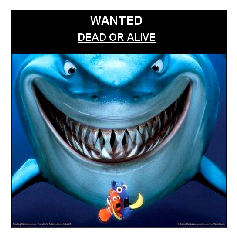

In [3]:
fish=mpimg.imread('fish.jpg')
imgplot = plt.imshow(fish)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

Using the edge.py file, we use the canny method to detect edges. The two values that can be modified correspond to the two thresholds in the canny method, corresponding to threshold gradient values.

In [ ]:
exec(open("./edge.py").read())


This sample demonstrates Canny edge detection.

Usage:
  edge.py [<video source>]

  Trackbars control edge thresholds.




2) Some fish segmentation

First, we compute superpixels of the fish image using several algorithms. In this instance, we used felzenszwalb, slic, quickshift and watershed algorithms as shown in scikit-image documentation. In felzenszwalb, the paramet is scale and influences the segment size. Quickshift does a hierarchical segmentation in multiple scales, the paremeter sigma controls the scale of the local density approximation and max_dist selects a level in the hierarchical segmentation. The SLIC algorithm works using Kmeans clustering. The parameters are compactness which trades off color-similarity and proximity (spacial) and n_segments chooses the number of centers for kmeans. The last method is the watershed algorithm which uses a compactness argument to control the proximity and similarity of segments. 

Felzenszwalb number of segments: 162
SLIC number of segments: 203
Quickshift number of segments: 471


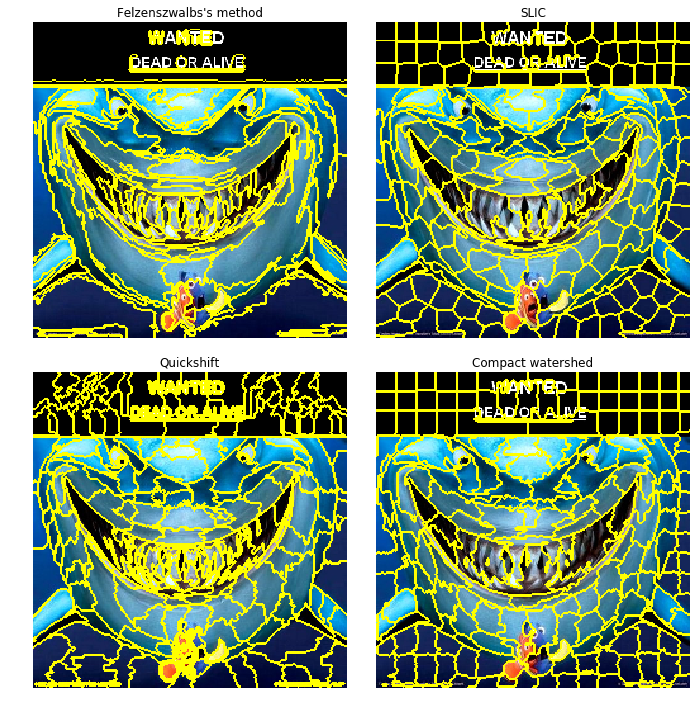

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(fish[::2, ::2])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()


Transforming the image in lab color space and performing kmeans with k = 5

In [5]:
import skimage.color as color
from sklearn.cluster import KMeans

fish_lab = color.rgb2lab(fish)
print(fish_lab.shape)



(500, 496, 3)


Fitting model on the data
Predicting color indices on the full image (k-means)


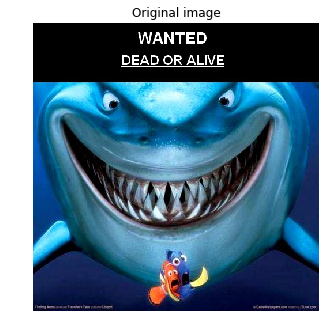

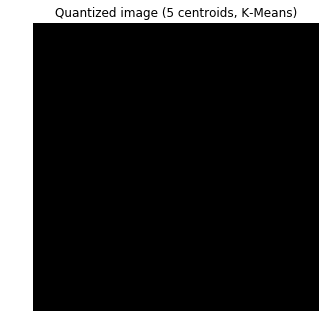

centers values
[[ 0.06538433  0.04360986 -0.12852099]
 [ 0.17186761 -0.03057571 -0.08775799]
 [ 0.01135163  0.00223238 -0.00319138]
 [ 0.29521589 -0.0516461  -0.08713734]
 [ 0.25208295  0.1172184   0.15966089]]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 5 # here colors are in lab format so can't be displayed properly

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
fish_arlab = np.array(fish_lab, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(fish_arlab.shape)
assert d == 3
image_array = np.reshape(fish_arlab, (w * h, d))

print("Fitting model on the data")
image_array_sample = shuffle(image_array, random_state=0)[:(w * h)-1]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image')
plt.imshow(fish)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (5 centroids, K-Means)')
plt.imshow(color.lab2rgb(recreate_image(kmeans.cluster_centers_, labels, w, h)))

plt.show()

print("centers values")
print(kmeans.cluster_centers_)

Using k means clustering on the rgb color space with k=5 and displaying the centroid values.

Fitting model on the data
Predicting color indices on the full image (k-means)


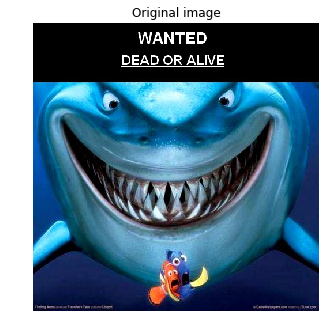

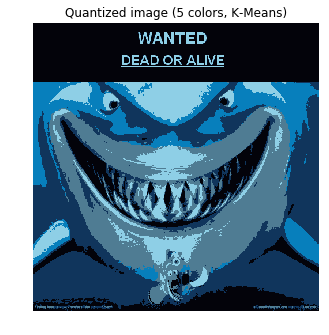

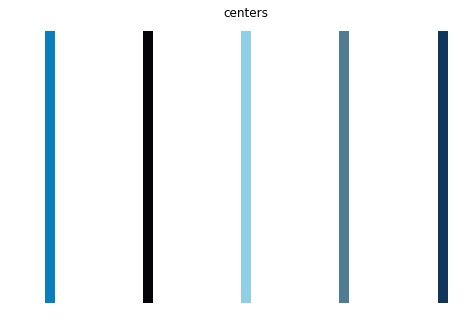

centers values
[[ 0.03039816  0.49921013  0.73860808]
 [ 0.01375298  0.01432447  0.04050767]
 [ 0.56027048  0.81505452  0.90312365]
 [ 0.31266944  0.48665304  0.5781285 ]
 [ 0.06353758  0.20998685  0.36211979]]


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 5

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
fish_ar = np.array(fish, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(fish_ar.shape)
assert d == 3
image_array = np.reshape(fish_ar, (w * h, d))

print("Fitting model on the data")
image_array_sample = shuffle(image_array, random_state=0)[:(w * h)-1]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image')
plt.imshow(fish)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (5 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('centers')
plt.plot([0, 0, 0, 0], [1, 2, 3, 4], linewidth=10, color = kmeans.cluster_centers_[0])
plt.plot([10, 10, 10, 10], [1, 2, 3, 4], linewidth=10,color = kmeans.cluster_centers_[1])
plt.plot([20, 20, 20, 20], [1, 2, 3, 4], linewidth=10,color = kmeans.cluster_centers_[2])
plt.plot([30, 30, 30, 30], [1, 2, 3, 4], linewidth=10, color = kmeans.cluster_centers_[3])
plt.plot([40, 40, 40, 40], [1, 2, 3, 4], linewidth=10,color = kmeans.cluster_centers_[4])

plt.show()

print("centers values")
print(kmeans.cluster_centers_)


Launching the kmeans file (requires an image and a number of clusters). It displays the image, an histogram showing for each cluster, the proportion of pixels assigned to that cluster and a bar chart representing the relative frequency of each of the color (the color itself and its proportion, which comes from the histogram).

5


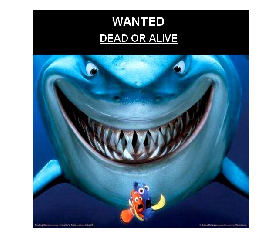

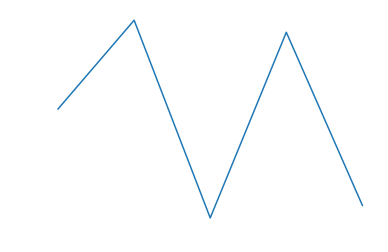

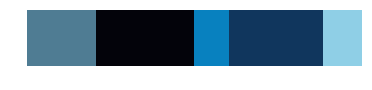

In [20]:
import sys
sys.argv[1:3] = ["-i", "fish.jpg"]
sys.argv[3:5] = ["-c", "5"]
exec(open("kmeans.py").read())

Running the grabcut example (we had a problem with the right click needed to draw the rectangle recognized as a contextual menu click, preventing us to draw the rectangle. We fixed it by replacing the right click by a middle mouse click). The file could not be launched from the notebook for some reasons. Provided is a screenshot of nemo grabcut.

![](grabcut.png)

Now we will use the opencv people detection on fish_part...

In [ ]:
import sys 

sys.argv[0:2] = ["peopledetect.py", "fish_part.jpg"]
exec(open("peopledetect.py").read())

![](fish_part2.png)

wee se that's not very accurate; Actually the algorith works pretty well on actual people. Here the algorithm try to find a human pattern on the face of the shark and that's why this zone is selected.

- On actual people : 

In [ ]:
sys.argv[0:2] = ["peopledetect.py", "people1.jpg"]
exec(open("peopledetect.py").read())

![](people1.jpg)
![](people2.png)

Now we will apply the opencv's find_obj aglorithm and try to find the best feature.

In [ ]:
import sys
sys.argv = ["find_obj.py", "--feature=sift", "fish.jpg", "fish_part.jpg"]
exec(open("find_obj.py").read())


Feature-based image matching sample.

Note, that you will need the https://github.com/opencv/opencv_contrib repo for SIFT and SURF

USAGE
  find_obj.py [--feature=<sift|surf|orb|akaze|brisk>[-flann]] [ <image1> <image2> ]

  --feature  - Feature to use. Can be sift, surf, orb or brisk. Append '-flann'
               to feature name to use Flann-based matcher instead bruteforce.

  Press left mouse button on a feature point to see its matching point.

using sift
img1 - 851 features, img2 - 133 features
matching...
53 / 81  inliers/matched


TypeError: only integer scalar arrays can be converted to a scalar index

![](obj1.png)

In [ ]:
import sys

sys.argv = ["find_obj.py", "--feature=surf", "fish.jpg", "fish_part.jpg"]
exec(open("find_obj.py").read())


Feature-based image matching sample.

Note, that you will need the https://github.com/opencv/opencv_contrib repo for SIFT and SURF

USAGE
  find_obj.py [--feature=<sift|surf|orb|akaze|brisk>[-flann]] [ <image1> <image2> ]

  --feature  - Feature to use. Can be sift, surf, orb or brisk. Append '-flann'
               to feature name to use Flann-based matcher instead bruteforce.

  Press left mouse button on a feature point to see its matching point.

using surf
img1 - 569 features, img2 - 68 features
matching...
12 / 50  inliers/matched


KeyboardInterrupt: 

![](obj2.png)

In [ ]:
import sys

sys.argv = ["find_obj.py", "--feature=orb", "fish.jpg", "fish_part.jpg"]
exec(open("find_obj.py").read())


Feature-based image matching sample.

Note, that you will need the https://github.com/opencv/opencv_contrib repo for SIFT and SURF

USAGE
  find_obj.py [--feature=<sift|surf|orb|akaze|brisk>[-flann]] [ <image1> <image2> ]

  --feature  - Feature to use. Can be sift, surf, orb or brisk. Append '-flann'
               to feature name to use Flann-based matcher instead bruteforce.

  Press left mouse button on a feature point to see its matching point.

using orb
img1 - 400 features, img2 - 149 features
matching...
4 / 4  inliers/matched


![](obj3.png)

The first feature used seems to be the best one. Indeed, this is the one that had gather the most of features and which one there is the less error

Finally, we will use the opencv's find contour method
Parameters : 

- init : initial coordinates 
- alpha : length of the snake shape.
- beta : Snake sofness
- w_line : Light attraction
- w_edge : Edge attraction

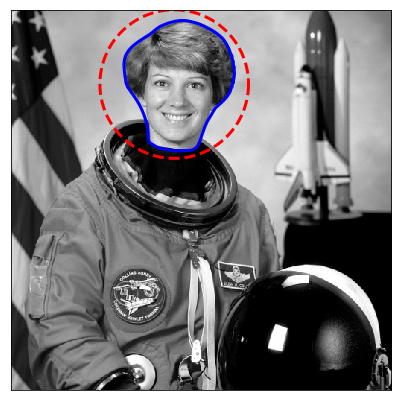

In [2]:
exec(open("active_contours_model.py").read())

If we slightly change some parameters...

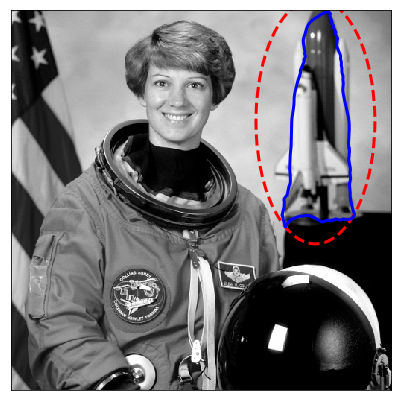

In [3]:
exec(open("active_contours_model2.py").read())